# DQN Training — CartPole-v1
Tracks per-step: **loss**, **Q values** (per action + per feature contribution), **reward**, **dominant feature**.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from collections import deque
import random
import pandas as pd

FEATURE_NAMES  = ["cart_pos", "cart_vel", "pole_angle", "pole_ang_vel"]
FEATURE_LABELS = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Ang. Vel"]

# ── Network ───────────────────────────────────────────────────────────────────
class QNetwork(nn.Module):
    def __init__(self, env, hidden_dim=64):
        super().__init__()
        self.layer1 = nn.Linear(np.array(env.observation_space.shape).prod(), hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, env.action_space.n)

    def forward(self, x):
        y = (self.layer1(x))
        return self.layer2(y)

    @property
    def w1(self): return self.layer1.weight
    @property
    def w2(self): return self.layer2.weight


# ── Feature contribution helper ───────────────────────────────────────────────
def get_feature_contributions(q_network, state):
    """Returns q_values (n_actions,), contributions (n_actions, n_feats), dominant_feat (n_actions,)."""
    with torch.no_grad():
        x    = torch.FloatTensor(state)
        z    = F.linear(x, q_network.w1, q_network.layer1.bias)
        #mask = (z > 0).float()
        #w_eff         = (q_network.w2 * mask) @ q_network.w1   # (n_actions, n_features)
        w_eff         = (q_network.w2) @ q_network.w1   # (n_actions, n_features)
        contributions = (w_eff * x.unsqueeze(0)).numpy()        # (n_actions, n_features)
        q_values      = q_network(x).numpy()                    # (n_actions,)
        dominant_feat = np.argmax(np.abs(contributions), axis=1)
    return q_values, contributions, dominant_feat


# ── Hyperparameters ───────────────────────────────────────────────────────────
LR            = 1e-3
GAMMA         = 0.99
BATCH_SIZE    = 64
BUFFER_SIZE   = 10000
EPSILON_START = 1.0
EPSILON_END   = 0.05
EPSILON_DECAY = 0.999
TARGET_UPDATE = 500
N_EPISODES    = 20000

# ── Setup ─────────────────────────────────────────────────────────────────────
env            = gym.make("CartPole-v1")
q_network      = QNetwork(env)
target_network = QNetwork(env)
target_network.load_state_dict(q_network.state_dict())
optimizer      = optim.Adam(q_network.parameters(), lr=LR)
memory         = deque(maxlen=BUFFER_SIZE)
epsilon        = EPSILON_START

step_log    = []   # one dict per env step
episode_log = []   # one dict per episode
global_step = 0

# ── Training loop ─────────────────────────────────────────────────────────────
for episode in range(N_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        q_values, contributions, dominant_feat = get_feature_contributions(q_network, state)

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(q_values))

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.append((state, action, reward, next_state, done))
        total_reward += reward

        # Training step
        loss_val = None
        if len(memory) > BATCH_SIZE:
            s_b, a_b, r_b, ns_b, d_b = zip(*random.sample(memory, BATCH_SIZE))
            s_b  = torch.FloatTensor(np.array(s_b))
            a_b  = torch.LongTensor(a_b).unsqueeze(1)
            r_b  = torch.FloatTensor(r_b)
            ns_b = torch.FloatTensor(np.array(ns_b))
            d_b  = torch.FloatTensor(d_b)

            current_q  = q_network(s_b).gather(1, a_b).squeeze()
            with torch.no_grad():
                target_q = r_b + (1 - d_b) * GAMMA * target_network(ns_b).max(1)[0]

            loss = F.mse_loss(current_q, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_val = loss.item()

        # Record step
        row = {
            "episode":      episode,
            "global_step":  global_step,
            "action":       action,
            "epsilon":      epsilon,
            "loss":         loss_val,
            "q_left":       float(q_values[0]),
            "q_right":      float(q_values[1]),
            "q_chosen":     float(q_values[action]),
            "dominant_feat": FEATURE_NAMES[dominant_feat[action]],
        }
        for fi, fname in enumerate(FEATURE_NAMES):
            row[f"contrib_left_{fname}"]   = float(contributions[0, fi])
            row[f"contrib_right_{fname}"]  = float(contributions[1, fi])
            row[f"contrib_chosen_{fname}"] = float(contributions[action, fi])

        step_log.append(row)
        state = next_state
        global_step += 1

    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    if episode % TARGET_UPDATE == 0:
        target_network.load_state_dict(q_network.state_dict())
        print(f"Episode {episode:4d} | Reward: {total_reward:6.1f} | w1 norm: {q_network.w1.norm().item():.2f}")

    episode_log.append({"episode": episode, "reward": total_reward})

env.close()

# Build DataFrames
df_steps = pd.DataFrame(step_log)
df_ep    = pd.DataFrame(episode_log)

# Episode-level aggregates (mean per episode)
df_ep_agg = df_steps.groupby("episode").agg(
    mean_loss=("loss",     "mean"),
    mean_q=("q_chosen",   "mean"),
    **{f"mean_contrib_{f}": (f"contrib_chosen_{f}", lambda x: x.abs().mean()) for f in FEATURE_NAMES}
).reset_index()
df_ep_agg = df_ep_agg.merge(df_ep, on="episode")

print(f"\nCollected {len(df_steps):,} steps across {N_EPISODES} episodes.")

Episode    0 | Reward:   30.0 | w1 norm: 4.37
Episode  500 | Reward:   15.0 | w1 norm: 4.26
Episode 1000 | Reward:   16.0 | w1 norm: 5.02
Episode 1500 | Reward:   10.0 | w1 norm: 6.45
Episode 2000 | Reward:   10.0 | w1 norm: 7.69
Episode 2500 | Reward:    9.0 | w1 norm: 8.43
Episode 3000 | Reward:   20.0 | w1 norm: 8.95
Episode 3500 | Reward:   10.0 | w1 norm: 8.54
Episode 4000 | Reward:   10.0 | w1 norm: 6.88
Episode 4500 | Reward:    9.0 | w1 norm: 6.43
Episode 5000 | Reward:    9.0 | w1 norm: 6.88
Episode 5500 | Reward:    9.0 | w1 norm: 7.96
Episode 6000 | Reward:   10.0 | w1 norm: 8.47
Episode 6500 | Reward:    9.0 | w1 norm: 8.27
Episode 7000 | Reward:    9.0 | w1 norm: 10.73
Episode 7500 | Reward:   10.0 | w1 norm: 13.09
Episode 8000 | Reward:   12.0 | w1 norm: 14.52
Episode 8500 | Reward:   13.0 | w1 norm: 15.11
Episode 9000 | Reward:   10.0 | w1 norm: 15.37
Episode 9500 | Reward:   10.0 | w1 norm: 14.86
Episode 10000 | Reward:   10.0 | w1 norm: 14.80
Episode 10500 | Reward:   

## Training Dashboard

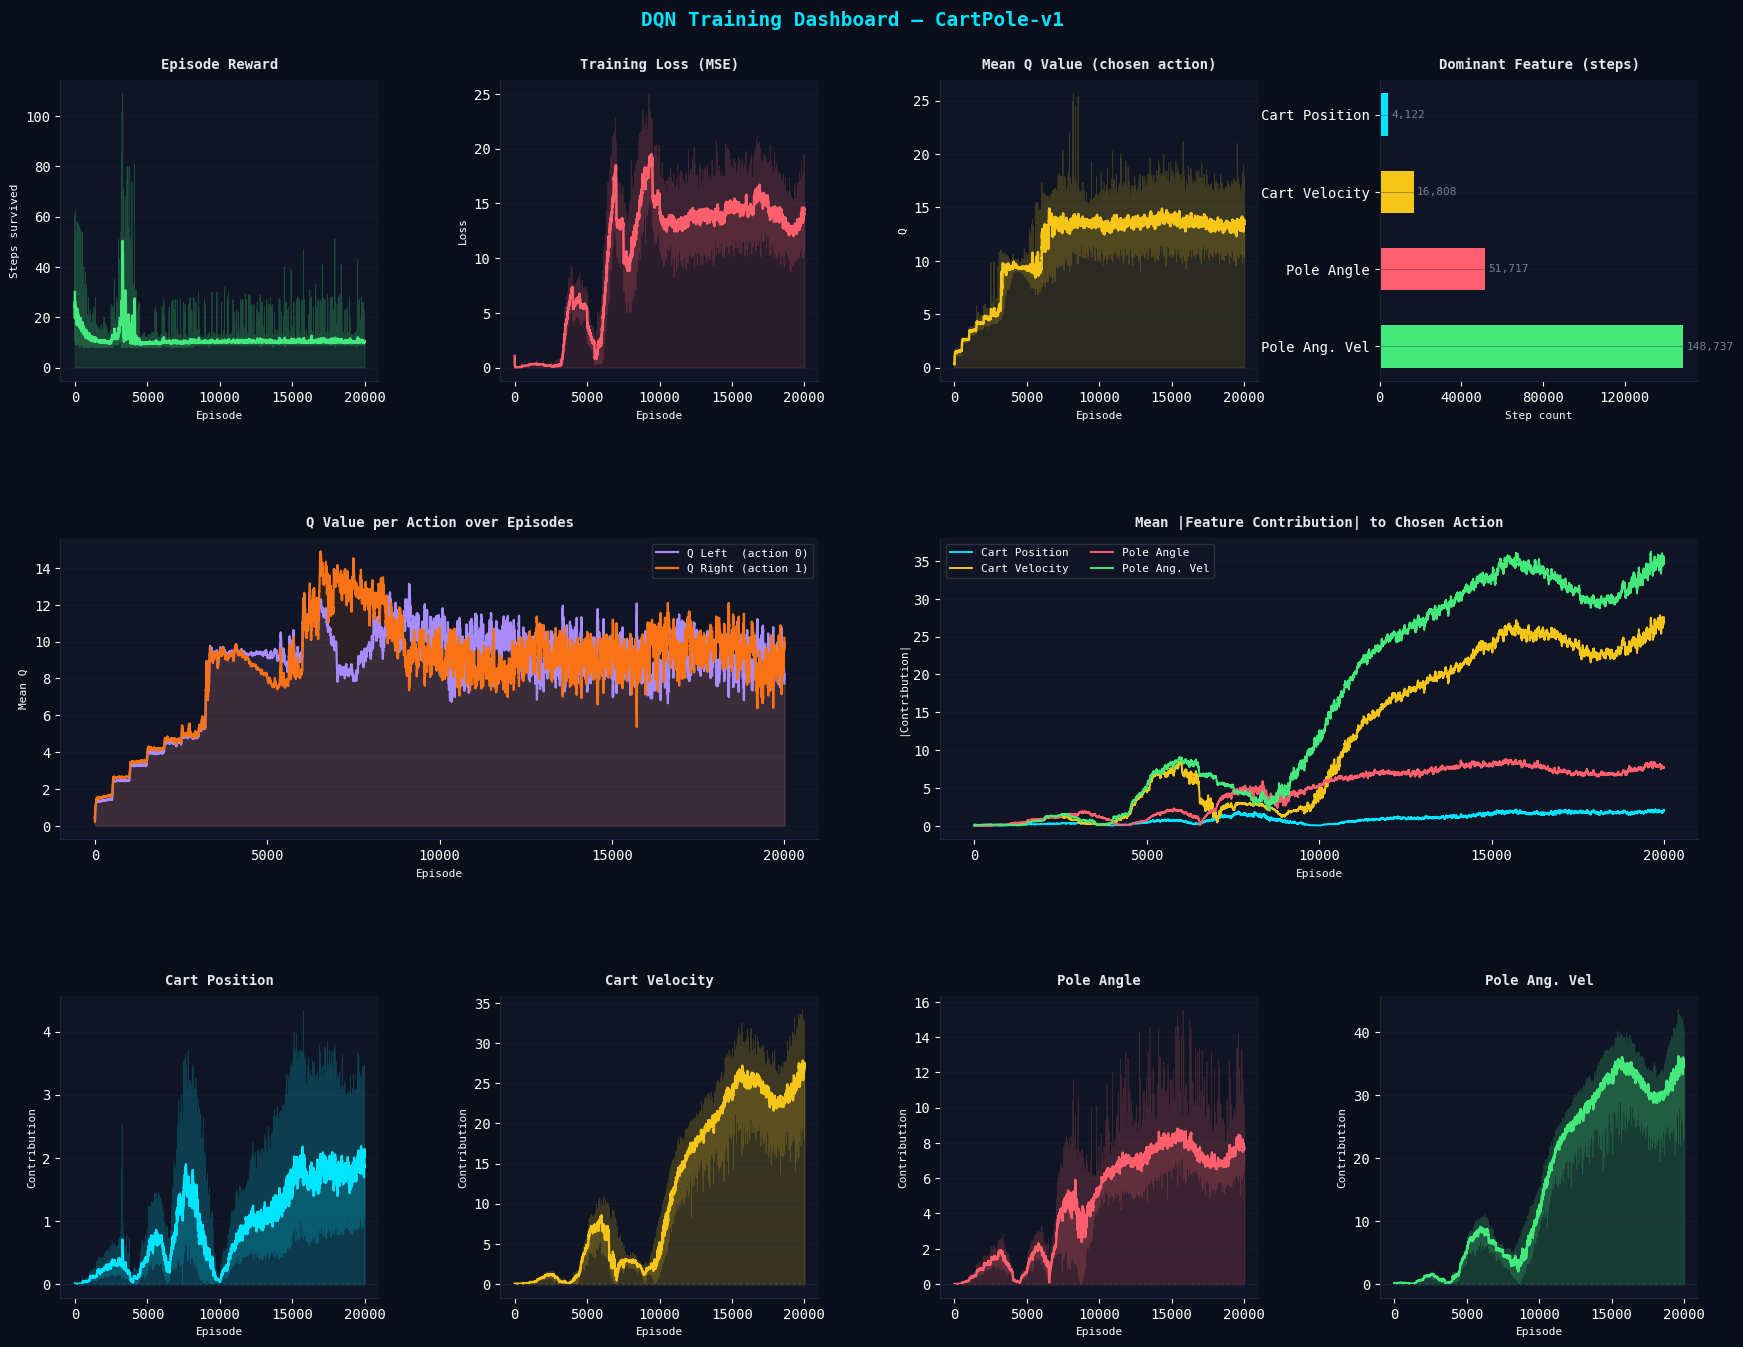

Saved dqn_dashboard.png


In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

# ── Style ─────────────────────────────────────────────────────────────────────
plt.rcParams.update({
    "figure.facecolor":  "#0a0e1a",
    "axes.facecolor":    "#0f1525",
    "axes.edgecolor":    "#1c2540",
    "axes.labelcolor":   "#ffffff",  # Changed to white
    "axes.titlecolor":   "#ffffff",  # Changed to white
    "xtick.color":       "#ffffff",  # Changed to white
    "ytick.color":       "#ffffff",  # Changed to white
    "grid.color":        "#1c2540",
    "grid.linewidth":    0.6,
    "text.color":        "#ffffff",  # Changed to white
    "font.family":       "monospace",
    "axes.spines.top":   False,
    "axes.spines.right": False,
})

COLORS = {
    "reward":   "#43e97b",
    "loss":     "#ff5f6d",
    "q":        "#f5c518",
    "features": ["#00e5ff", "#f5c518", "#ff5f6d", "#43e97b"],
    "left":     "#a78bfa",
    "right":    "#f97316",
    "fill":     0.15,
}

def smooth(s, w=30):
    """Pandas rolling mean."""
    return s.rolling(w, min_periods=1).mean()

def styled_ax(ax, title, xlabel="Episode", ylabel=""):
    ax.set_title(title, fontsize=10, fontweight="bold", pad=8, color="#e2e8f0")
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.grid(True, axis="y", alpha=0.4)
    ax.xaxis.set_major_locator(MaxNLocator(5, integer=True))

def fill_between(ax, x, y, color, alpha=0.12):
    ax.fill_between(x, y, alpha=alpha, color=color)

# ── Layout ────────────────────────────────────────────────────────────────────
#  Row 0: Reward  |  Loss  |  Q-value
#  Row 1: Q per action (left vs right)  |  Dominant feature (bar)
#  Row 2: Feature contributions [4 subplots]

fig = plt.figure(figsize=(18, 14), facecolor="#0a0e1a")
fig.suptitle("DQN Training Dashboard — CartPole-v1", fontsize=14,
             fontweight="bold", color="#00e5ff", y=0.98)

gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.52, wspace=0.38,
                       left=0.06, right=0.97, top=0.93, bottom=0.06)

ep  = df_ep_agg["episode"]

# ── 1. Reward ─────────────────────────────────────────────────────────────────
ax_rew = fig.add_subplot(gs[0, 0])
raw = df_ep_agg["reward"]
smo = smooth(raw)
ax_rew.plot(ep, raw, color=COLORS["reward"], alpha=0.25, linewidth=0.6)
ax_rew.plot(ep, smo, color=COLORS["reward"], linewidth=1.8, label="Smoothed")
fill_between(ax_rew, ep, smo, COLORS["reward"])
styled_ax(ax_rew, "Episode Reward", ylabel="Steps survived")

# ── 2. Loss ───────────────────────────────────────────────────────────────────
ax_loss = fig.add_subplot(gs[0, 1])
loss_s = df_ep_agg["mean_loss"].dropna()
ep_l   = df_ep_agg.loc[loss_s.index, "episode"]
smo_l  = smooth(loss_s)
ax_loss.plot(ep_l, loss_s, color=COLORS["loss"], alpha=0.2, linewidth=0.6)
ax_loss.plot(ep_l, smo_l,  color=COLORS["loss"], linewidth=1.8)
fill_between(ax_loss, ep_l, smo_l, COLORS["loss"])
styled_ax(ax_loss, "Training Loss (MSE)", ylabel="Loss")

# ── 3. Mean Q value ───────────────────────────────────────────────────────────
ax_q = fig.add_subplot(gs[0, 2])
q_s  = smooth(df_ep_agg["mean_q"])
ax_q.plot(ep, df_ep_agg["mean_q"], color=COLORS["q"], alpha=0.2, linewidth=0.6)
ax_q.plot(ep, q_s, color=COLORS["q"], linewidth=1.8)
fill_between(ax_q, ep, q_s, COLORS["q"])
styled_ax(ax_q, "Mean Q Value (chosen action)", ylabel="Q")

# ── 4. Dominant feature pie/bar ───────────────────────────────────────────────
ax_dom = fig.add_subplot(gs[0, 3])
dom_counts = df_steps["dominant_feat"].value_counts().reindex(FEATURE_NAMES, fill_value=0)
bars = ax_dom.barh(
    FEATURE_LABELS, dom_counts.values,
    color=COLORS["features"], edgecolor="none", height=0.55
)
for bar, val in zip(bars, dom_counts.values):
    ax_dom.text(bar.get_width() + max(dom_counts) * 0.01, bar.get_y() + bar.get_height() / 2,
                f"{val:,}", va="center", ha="left", fontsize=8, color="#718096")
styled_ax(ax_dom, "Dominant Feature (steps)", xlabel="Step count", ylabel="")
ax_dom.invert_yaxis()

# ── 5. Q left vs Q right ──────────────────────────────────────────────────────
ax_ql = fig.add_subplot(gs[1, :2])
q_left_ep  = df_steps.groupby("episode")["q_left"].mean()
q_right_ep = df_steps.groupby("episode")["q_right"].mean()
ax_ql.plot(q_left_ep.index,  smooth(q_left_ep),  color=COLORS["left"],  linewidth=1.6, label="Q Left  (action 0)")
ax_ql.plot(q_right_ep.index, smooth(q_right_ep), color=COLORS["right"], linewidth=1.6, label="Q Right (action 1)")
fill_between(ax_ql, q_left_ep.index,  smooth(q_left_ep),  COLORS["left"])
fill_between(ax_ql, q_right_ep.index, smooth(q_right_ep), COLORS["right"])
styled_ax(ax_ql, "Q Value per Action over Episodes", ylabel="Mean Q")
ax_ql.legend(fontsize=8, framealpha=0.15)

# ── 6. All feature contributions on one plot ──────────────────────────────────
ax_fc = fig.add_subplot(gs[1, 2:])
for fi, fname in enumerate(FEATURE_NAMES):
    col = f"mean_contrib_{fname}"
    s   = smooth(df_ep_agg[col])
    ax_fc.plot(ep, s, color=COLORS["features"][fi], linewidth=1.4, label=FEATURE_LABELS[fi])
styled_ax(ax_fc, "Mean |Feature Contribution| to Chosen Action", ylabel="|Contribution|")
ax_fc.legend(fontsize=8, framealpha=0.15, ncol=2)

# ── 7. Individual feature contribution plots ──────────────────────────────────
for fi, (fname, flabel) in enumerate(zip(FEATURE_NAMES, FEATURE_LABELS)):
    ax = fig.add_subplot(gs[2, fi])
    col = f"mean_contrib_{fname}"
    raw_f = df_ep_agg[col]
    smo_f = smooth(raw_f)
    c = COLORS["features"][fi]
    ax.plot(ep, raw_f, color=c, alpha=0.2, linewidth=0.5)
    ax.plot(ep, smo_f, color=c, linewidth=1.6)
    ax.axhline(0, color="#1c2540", linewidth=0.8, linestyle="--")
    fill_between(ax, ep, smo_f.clip(lower=0), c, alpha=0.18)
    fill_between(ax, ep, smo_f.clip(upper=0), c, alpha=0.18)
    styled_ax(ax, flabel, ylabel="Contribution")

plt.savefig("dqn_dashboard_linear.png", dpi=150, bbox_inches="tight", facecolor="#0a0e1a")
plt.show()
print("Saved dqn_dashboard.png")

## Numeric Summary

In [3]:
print("=== Training Summary ===")
print(f"  Max reward:          {df_ep['reward'].max():.0f}")
print(f"  Final 100-ep mean:   {df_ep['reward'].tail(100).mean():.1f}")
print(f"  Final mean loss:     {df_ep_agg['mean_loss'].dropna().tail(100).mean():.4f}")
print(f"  Final mean Q:        {df_ep_agg['mean_q'].tail(100).mean():.3f}")

print("\n=== Dominant Feature Distribution ===")
dom = df_steps["dominant_feat"].value_counts()
for f, c in dom.items():
    print(f"  {f:20s}: {c:6,}  ({100*c/len(df_steps):.1f}%)")

print("\n=== Mean |Contribution| per Feature (last 500 eps) ===")
last = df_ep_agg.tail(500)
for fname, flabel in zip(FEATURE_NAMES, FEATURE_LABELS):
    print(f"  {flabel:20s}: {last[f'mean_contrib_{fname}'].mean():.4f}")

=== Training Summary ===
  Max reward:          109
  Final 100-ep mean:   10.3
  Final mean loss:     14.1268
  Final mean Q:        13.299

=== Dominant Feature Distribution ===
  pole_ang_vel        : 148,737  (67.2%)
  pole_angle          : 51,717  (23.4%)
  cart_vel            : 16,808  (7.6%)
  cart_pos            :  4,122  (1.9%)

=== Mean |Contribution| per Feature (last 500 eps) ===
  Cart Position       : 1.9342
  Cart Velocity       : 26.2995
  Pole Angle          : 7.9700
  Pole Ang. Vel       : 34.5094
